In [1]:
import sys
import os
import time
import numpy as np
import tensorflow as tf
import gpflow
import soundfile
import pickle
sys.path.append('../../../../')
import gpitch
from gpitch.amtgp import logistic
from gpitch import myplots
import soundfile
import sounddevice
import peakutils
from scipy import signal
from scipy.fftpack import fft, ifft, ifftshift
from scipy import signal

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 3)  # set plot size

In [3]:
pickleloc = '../../../../../results/files/svi/script/'
bounds = [21, 109]
midi = np.asarray([str(i) for i in range(bounds[0], bounds[1])]).reshape(-1,)

In [4]:
Np = 88
fs = 16e3
m = [pickle.load(open(pickleloc + "maps_pitch_" + midi[i] + ".p", "rb")) for i in range(Np)]
N = m[0].x.value.size
x = m[0].x.value.copy()

In [5]:
filename = '../../../../../datasets/maps/test_data/segment4-down.wav'
ytest, fs = soundfile.read(filename)
ytest = ytest.reshape(-1, 1)
Ntest = ytest.size
xtest = np.linspace(0, (Ntest-1.)/fs, Ntest).reshape(-1, 1)

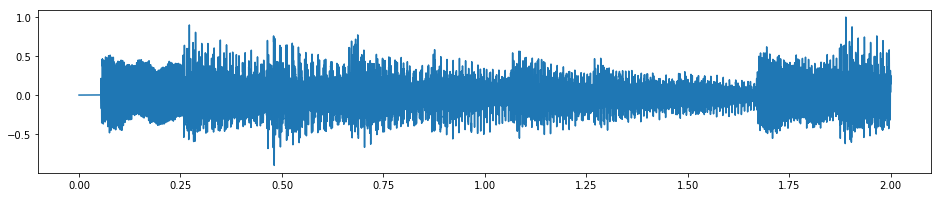

In [6]:
plt.figure()
plt.plot(xtest, ytest)

In [7]:
dec = 320
maxiter = 200
minibatch_size = 200
learning_rate = 0.01
ztest = xtest[::dec].copy()
#ztest.shape

(100, 1)

In [8]:
m_bg = pickle.load(open(pickleloc + "maps_background.p", "rb")) # load background model

Analysing pitch 21
Analysing pitch 22
Analysing pitch 23
Analysing pitch 24
Analysing pitch 25
Analysing pitch 26
Analysing pitch 27
Analysing pitch 28
Analysing pitch 29
Analysing pitch 30
Analysing pitch 31
Analysing pitch 32
Analysing pitch 33


KeyboardInterrupt: 

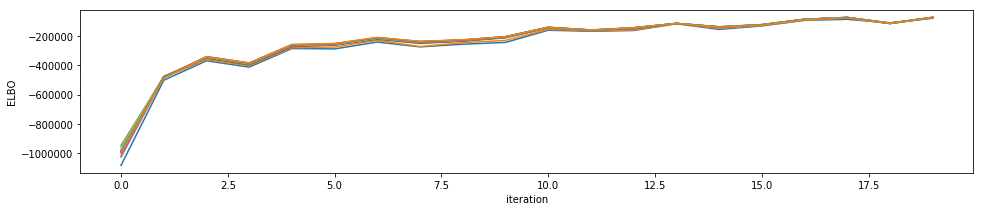

In [9]:
all_mean_f = [None]*Np
all_mean_g = [None]*Np
all_var_f = [None]*Np
all_var_g = [None]*Np

a, b = 0, Ntest
for i in range(Np):
    print('Analysing pitch ' + str(midi[i]))
    kf = [m[i].kern_com, m_bg.kern_com]
    kg = [m[i].kern_act, m_bg.kern_act]
    mloo = gpitch.loogp.LooGP(X=xtest, Y=ytest, kf=kf, kg=kg, Z=ztest, 
                              minibatch_size=minibatch_size)
    mloo.optimize_svi(maxiter=maxiter, learning_rate=learning_rate)
    
    mean_f, var_f, mean_g, var_g = mloo.predict_all(xtest[a:b])
    
    all_mean_f[i] = list(mean_f)
    all_mean_g[i] = list(mean_g)
    all_var_f[i] = list(var_f)
    all_var_g[i] = list(var_g)

    plt.figure(1)
    plt.plot(-np.array(mloo.logf))
    plt.xlabel('iteration')
    plt.ylabel('ELBO')

    tf.reset_default_graph()

TypeError: 'NoneType' object has no attribute '__getitem__'

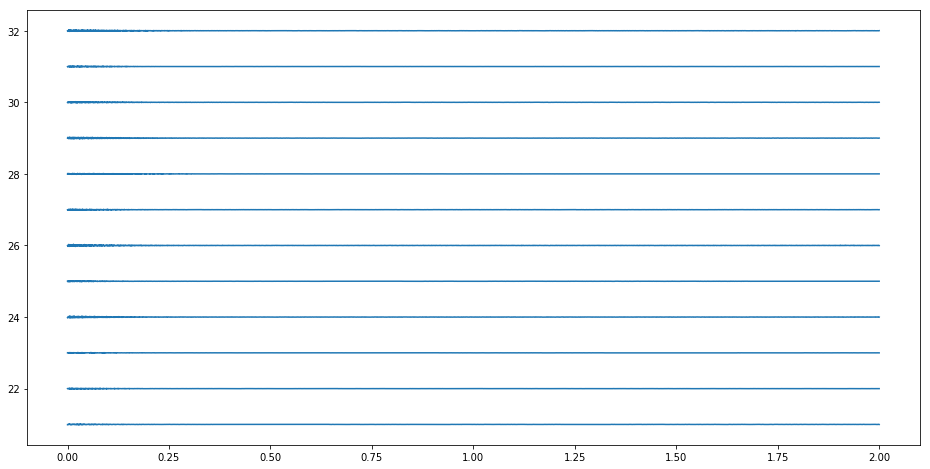

In [10]:
piano_roll = np.zeros((Np, Ntest))
for i in range(Np):
    source = logistic(all_mean_g[i][0]) * all_mean_f[i][0]
    piano_roll[i, :] = source.copy()
    plt.figure(1, figsize=(16, 8))
    plt.plot(xtest, source + float(midi[i]), 'C0')
    
plt.figure()
plt.imshow(piano_roll, aspect='auto')
plt.colorbar()